In [112]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV, Random, Distributions, Printf, LinearAlgebra, StatsPlots
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

# Define the likelihood function
# This function calculates the likelihood of the model given the data and the parameters
function likelihood(params, data)
  # Calculate the predicted values of the model
  y_pred = model(params)

  # Calculate the sum of squared errors
  sse = sum((y_pred .- data) .^ 2)

  # Return the likelihood of the model given the data and the parameters
  return sse
end

# Define Marmarou model
function model(params)
  Rcsf = params[1] # Resistance to csf outflow
  E = params[2] # Brain elastance coefficient
  P_0 = params[3] # Reference ICP

  I_b = (Data["P_b"] - P_0) / Rcsf # CSF formation rate

  infstart = Data["infusion_start_frame"]
  infend = Data["infusion_end_frame"]
  I_inf = Data["I_inf"]

  Rn = Data["Rn"] # Needle resistance (one-needle)
  ΔP = Data["P_b"] - P_0
  icp = Data["ICP"]
  It = I_b + I_inf
  Pm = zeros(infend - infstart + 1)
  errorVal = 0.0

  for i = infstart:infend
    t = (i - infstart) / 6
    Pm[i-infstart+1] = It * ΔP / (I_b + (I_inf * exp(-E * It * t))) + P_0 + (I_inf * Rn)
  end

  return Pm
end

# Define the acceptance probability function
# This function calculates the probability of accepting a proposed new state
# based on the current state, the proposed new state, and the physiologically
# defined ranges for the parameters
function acceptance_probability(current, proposed, ranges, data)
  # Check if any of the proposed parameter values are outside of the defined ranges
  if any(proposed .< ranges[:, 1]) || any(proposed .> ranges[:, 2])
    # If any of the proposed values are outside of the defined ranges, return 0
    return 0
  else
    # If all of the proposed values are within the defined ranges,
    # return the probability of accepting the proposed new state
    # based on the current state and the proposed new state
    current = likelihood(current, data)
    proposed = likelihood(proposed, data)
    return exp((current - proposed) / 2)
  end
end

# Define the Metropolis-Hastings algorithm
function metropolis_hastings(data, means, stddevs, ranges, num_samples)
  # Initialize the Markov chain with the starting point
  # The starting point is the mean of the prior distributions
  chain = zeros(num_samples, 3)
  chisave = zeros(num_samples)
  chain[1, :] = means

  # Run the Markov chain for the specified number of samples

  for i in 2:num_samples
    # Sample a proposed new state from the normal distributions centered at the current state
    current = chain[i-1, :]
    proposed = randn(3) .* stddevs .+ current
    # Calculate the acceptance probability of the proposed new state
    p = acceptance_probability(current, proposed, ranges, data)
    chisave[i] = likelihood(current, data) # Undesirable global assignment
    # Accept the proposed new state with the calculated probability
    if rand() < p
      # If the proposed state is accepted, append it to the Markov chain
      chain[i, :] .= proposed
    else
      # If the proposed state is not accepted, append the current state again
      chain[i, :] .= current
    end
  end

  # Return the Markov chain after running for the specified number of samples
  return chain, chisave
end

# Define the main function
# function main()
  # Load the data
  datapath = "/Users/jjc/CSF/Recordings/"
  path = pwd()
  savepath = "/Users/jjc/CSF/"
  files = glob("*.hdf5", datapath)
  j = 100
  filename = files[j]

  global Data = readCSF(filename)
  infstart = Data["infusion_start_frame"]
  infend = Data["infusion_end_frame"]
  data = Data["ICP"][infstart:infend]

  # Specify parameter ranges
  # TODO: add I_b
  lowerbound = [0.01, 0.01, -10.0]
  upperbound = [50.0, 1.0, Data["P_b"]]
  ranges = hcat(lowerbound, upperbound)

  # Define the starting point of the Markov chain
  # This is the mean of the prior distributions
  # means = [15.5, 0.18, 2.8]
  means = zeros(3).+0.01

  # Define the standard deviations of the prior distributions
  # stddevs = [10.36, 0.14, 10.54]
  stddevs = zeros(3).+0.1

  # Run the Metropolis-Hastings algorithm for the specified number of samples
  num_samples = 100000
  burnin = Int64(round(0.2*num_samples,digits=0))
  chain, chisave = metropolis_hastings(data, means, stddevs, ranges, num_samples)
  chain = chain[burnin:end,:]
  Ib_chain = (Data["P_b"] .- chain[:,3]) ./ chain[:,1]
# end

# Calculate the means and standard deviations of the posterior distributions
# of the fitted parameters
function mean_and_stddev(chain)
  params_modes = zeros(3)
  params_modes[1] = StatsBase.mode(chain[:, 1])
  params_modes[2] = StatsBase.mode(chain[:, 2])
  params_modes[3] = StatsBase.mode(chain[:, 3])
  params_means = mean(chain, dims=1)
  params_stddevs = std(chain, dims=1)
  return params_modes, params_means, params_stddevs
end
params_modes, params_means, params_stddevs = mean_and_stddev(chain)

# Print the results
println(@sprintf("Means of the posterior distributions: [%0.2f, %0.2f, %0.2f]", params_means...))
println(@sprintf("Standard deviations of the posterior distributions: [%0.2f, %0.2f, %0.2f]", params_stddevs...))

Rcsf = params_modes[1]
E = params_modes[2]
P_0 = params_modes[3]
I_b = (Data["P_b"] - P_0) / Rcsf
rmserr = calc_model_plot(I_b, E, P_0)[2]



Means of the posterior distributions: [12.63, 0.45, 7.84]
Standard deviations of the posterior distributions: [0.21, 0.08, 1.81]


0.1895

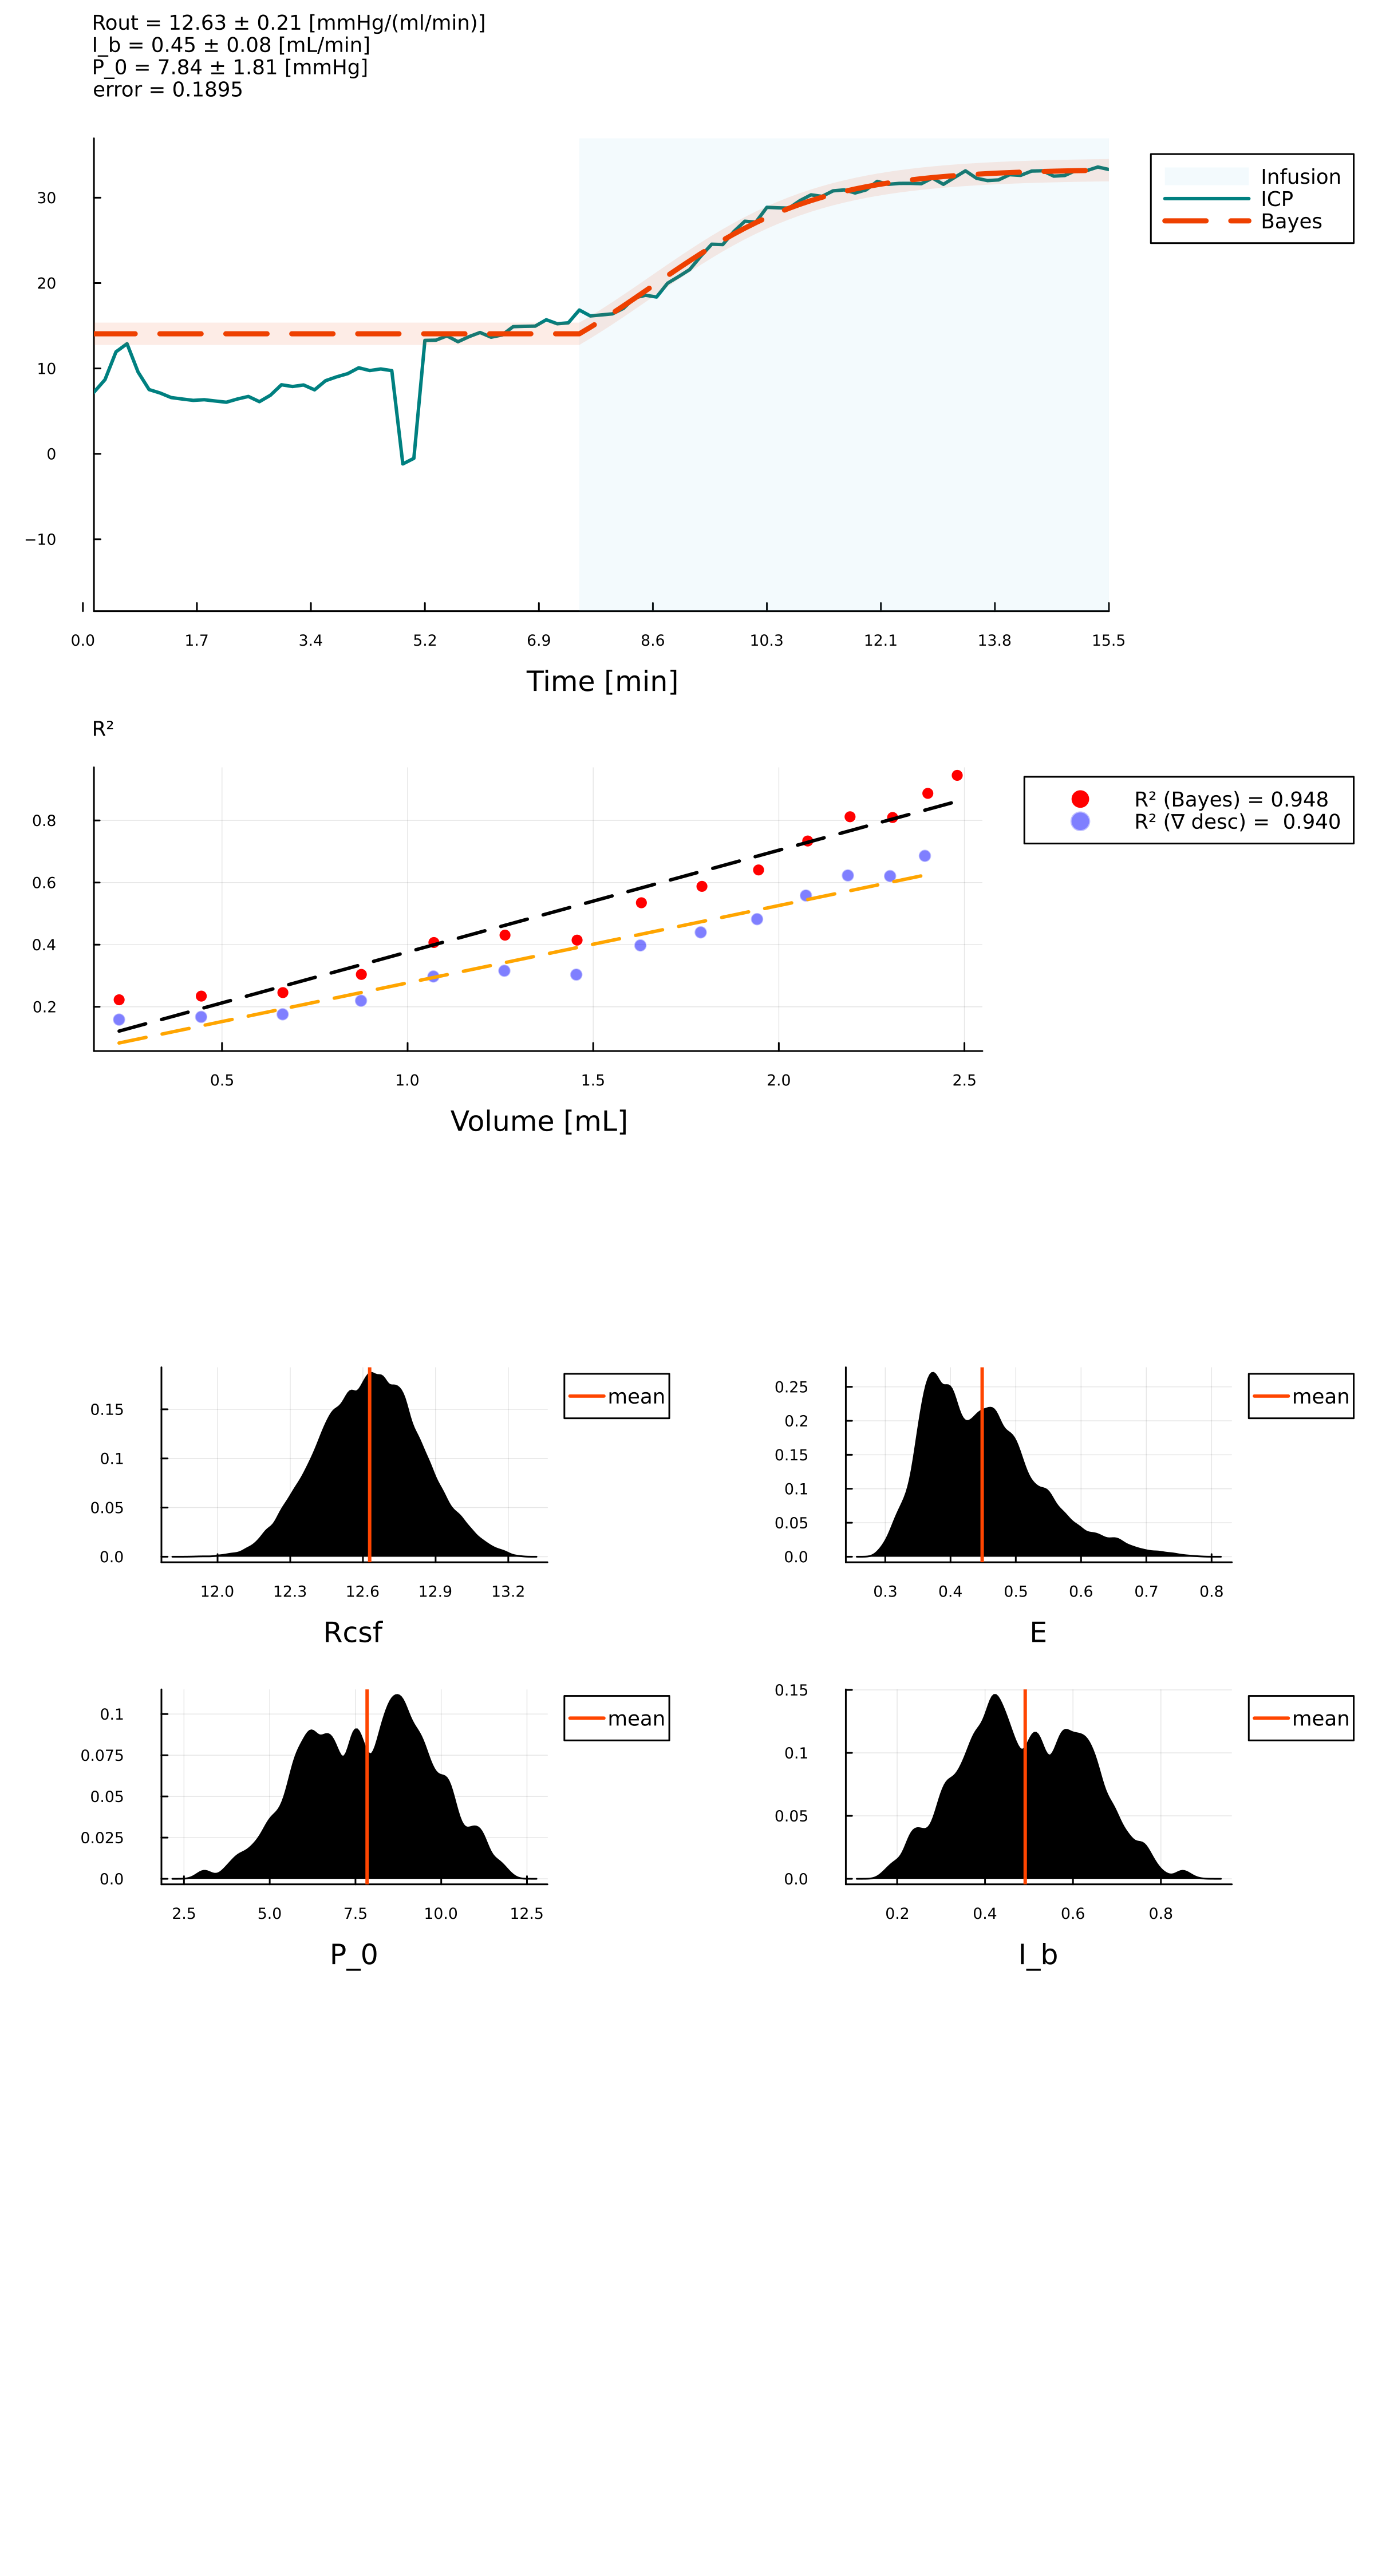

In [117]:
h1 = plotmodel(I_b, E, P_0, params_means, params_stddevs, "dar", "")

title!( @sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", params_means[1], params_stddevs[1]) * 
        @sprintf("I_b = %0.2f ± %0.2f [mL/min]\n", params_means[2], params_stddevs[2]) * 
        @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", params_means[3], params_stddevs[3]) *
        @sprintf("error = %0.4f \n", rmserr),
        titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

R_bayes = Rcsf
R_icm = Data["Rcsf"]
P0_bayes = P_0
P0_icm = Data["P_0"]
nr=1

Pm = data;

bayescol=:red
icmcol=:blue
bgcolor=:white

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_bayes[nr], P0_bayes[nr])
h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label= @sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_icm[nr], P0_icm[nr])
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, 
label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!("R²")


h3 = density(chain[:,1],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h3)[1][2])
hist_fit = Distributions.fit(Histogram, chain[:,1])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h3, [mean(chain[:,1])],lw=2,label="mean", linecolor=:orangered, xlabel="Rcsf", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")

h4 = density(chain[:,2],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h4)[1][2])
hist_fit = Distributions.fit(Histogram, chain[:,2])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h4, [mean(chain[:,2])],lw=2,label="mean", linecolor=:orangered, xlabel="E", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")

h5 = density(chain[:,3],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h5)[1][2])
hist_fit = Distributions.fit(Histogram, chain[:,3])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h5, [StatsBase.mean(chain[:,3])],lw=2,label="mean", linecolor=:orangered, xlabel="P_0", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")

h6 = density(Ib_chain,label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h6)[1][2])
hist_fit = Distributions.fit(Histogram, Ib_chain)
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h6, [StatsBase.mean(Ib_chain)],lw=2,label="mean", linecolor=:orangered, xlabel="I_b", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")

plot(h1, h2, h3, h4, h5, h6, layout=[grid(2,1, heights=[.5,.3]),grid(2,2, heights=[.2, .2, .2, .2])], size=(800,1500), dpi=300, tickfontsize=6)


In [105]:
println(@sprintf("I_b (posthoc) = %0.2f\n", I_b))
println(@sprintf("I_b (mean) = %0.2f", mean(Ib_chain)))
println(@sprintf("I_b (mode) = %0.2f", StatsBase.mode(Ib_chain)))


In [ ]:
function scale_to_01(v::Vector)
    v_min = minimum(v)
    v_max = maximum(v)
    if v_min == v_max
        return fill(0.5, length(v))
    else
        return (v .- v_min) ./ (v_max - v_min)
    end
end

ch1 = scale_to_01(chain[:,1]./upperbound[1])
ch2 = scale_to_01(chain[:,2]./upperbound[2])
ch3 = scale_to_01(chain[:,3]./upperbound[3])

# plot([ch1[1:100:end] ch2[1:100:end] ch3[1:100:end]])
plot([chain[1:100:end,1]./upperbound[1], chain[1:100:end,2]./upperbound[2], chain[1:100:end,3]./upperbound[3]], ylim=[0,1])
hline!([mean(chain[:,1]./upperbound[1]), mean(chain[:,2]./upperbound[2]), mean(chain[:,3]./upperbound[3])], linewidth=2)